In [1]:
import os
import pandas as pd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("imports successful")

imports successful


In [2]:
df = pd.read_csv('data_cleaned/housing_imputed.csv')
col_df = pd.read_csv('data_cleaned/wages_cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42768 entries, 0 to 42767
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        42768 non-null  object 
 1   price         42768 non-null  float64
 2   bed           42768 non-null  float64
 3   bath          42768 non-null  float64
 4   acre_lot      42768 non-null  float64
 5   full_address  42768 non-null  object 
 6   street        42699 non-null  object 
 7   city          42768 non-null  object 
 8   state         42768 non-null  object 
 9   zip_code      42768 non-null  float64
 10  house_size    42768 non-null  float64
 11  sold_date     42768 non-null  object 
dtypes: float64(6), object(6)
memory usage: 3.9+ MB


In [4]:
lookup = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "VI": "Virgin Islands",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

col_df['state'] = col_df['state'].map(lookup)
col_df.head(5)

,area,state,annual_median
0,Abilene,Texas,47096.596491
1,Aguadilla-Isabela,Puerto Rico,28787.163462
2,Akron,Ohio,54828.518519
3,Albany,Georgia,46217.944664
4,Albany,Oregon,52356.785714


### The annual median age did not include data for Virgin Islands. We only have 2 entries, so we will drop these values:

In [5]:
print(len(df[(df['state'] == 'Virgin Islands')]))
print(f'before drop: {len(df)}')
df = df[~(df['state'] == 'Virgin Islands')]
print(f'after drop: {len(df)}')

2
before drop: 42768
after drop: 42766


In [6]:
med_by_state = col_df.groupby(by='state').median()
med_by_state.reset_index(inplace=True)
med_by_state = med_by_state.rename(columns = {'index':'state'})
med_by_state.head()

,state,annual_median
0,Alabama,49105.054039
1,Alaska,64067.490421
2,Arizona,51482.227723
3,Arkansas,43961.711857
4,California,61602.231161


In [7]:
df = df.merge(col_df[['area', 'annual_median']], left_on='city', right_on='area', how='left').drop('area', axis=1)
df = df.merge(med_by_state[['state', 'annual_median']], left_on='state', right_on='state', how='left')
df.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,annual_median_x,annual_median_y
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,2019-06-28,NaN,28377.754237
1,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,2014-06-25,NaN,61829.452055
2,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,2012-10-12,NaN,61829.452055
3,for_sale,384900.0,3.0,2.0,0.46,"45 Hampden Ln, Agawam, MA, 01001",45 Hampden Ln,Agawam,Massachusetts,1001.0,1476.0,1986-11-20,NaN,61829.452055
4,for_sale,199999.0,3.0,2.0,1.76,"88 South St, Agawam, MA, 01001",88 South St,Agawam,Massachusetts,1001.0,1968.0,2008-09-19,NaN,61829.452055


### Now we merge the columns, taking cost of living_x where city matched up, or cost_of_living_index_y if city cost of living is Na

In [8]:
df = df.assign(annual_median=df['annual_median_x'].mask(df['annual_median_x'].isna(), df['annual_median_y']))
df = df.drop(['annual_median_x', 'annual_median_y'], axis=1)
df.head(5)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,annual_median
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,2019-06-28,28377.754237
1,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,2014-06-25,61829.452055
2,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,2012-10-12,61829.452055
3,for_sale,384900.0,3.0,2.0,0.46,"45 Hampden Ln, Agawam, MA, 01001",45 Hampden Ln,Agawam,Massachusetts,1001.0,1476.0,1986-11-20,61829.452055
4,for_sale,199999.0,3.0,2.0,1.76,"88 South St, Agawam, MA, 01001",88 South St,Agawam,Massachusetts,1001.0,1968.0,2008-09-19,61829.452055


In [9]:
# Cost of Living Index updated for all values
df['annual_median'].isna().any()

False

In [10]:
df.dtypes

status            object
price            float64
bed              float64
bath             float64
acre_lot         float64
full_address      object
street            object
city              object
state             object
zip_code         float64
house_size       float64
sold_date         object
annual_median    float64
dtype: object

## 1. Make sure columns are correct types
sold_date is a date not an object

In [11]:
df['sold_date'] = pd.to_datetime(df['sold_date'])
# dropped_df['sold_date'] = pd.to_datetime(dropped_df['sold_date'])

df.dtypes

status                   object
price                   float64
bed                     float64
bath                    float64
acre_lot                float64
full_address             object
street                   object
city                     object
state                    object
zip_code                float64
house_size              float64
sold_date        datetime64[ns]
annual_median           float64
dtype: object

In [12]:
df['sold_date'].head(5)

0   2019-06-28
1   2014-06-25
2   2012-10-12
3   1986-11-20
4   2008-09-19
Name: sold_date, dtype: datetime64[ns]

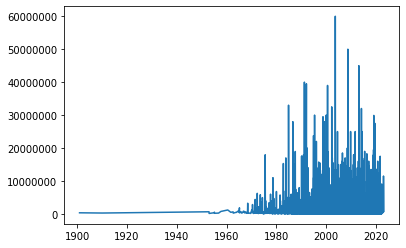

In [13]:
def plot_line(df, xfeat, yfeat):
    df = df.sort_values(by=xfeat)
    fig, ax = plt.subplots()
    ax.plot(df[xfeat], df[yfeat])
    ax.ticklabel_format(axis='y', style='plain')
    plt.show()
    
plot_line(df, 'sold_date', 'price')
# lp = sns.lineplot(data=df, x='sold_date', y='price')

In [14]:
df[df['price'] > 600000000]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,annual_median


## 2. Price outliers
Drop this outlier as it is vastly outside the average

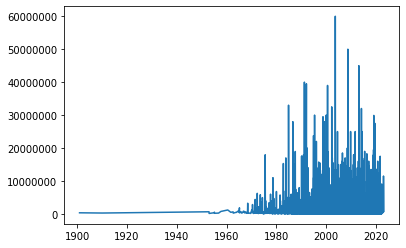

In [15]:
df = df[df['price'] < 600000000]
plot_line(df, 'sold_date', 'price')

### Now convert datetime to a timestamp so we can use it for predictions

In [16]:
df['sold_date'] = df['sold_date'].apply(lambda x: x.timestamp())
# dropped_df['sold_date'] = dropped_df['sold_date'].apply(lambda x: x.timestamp())
df.head(5)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,annual_median
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,1.561680e+09,28377.754237
1,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,1.403654e+09,61829.452055
2,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,1.350000e+09,61829.452055
3,for_sale,384900.0,3.0,2.0,0.46,"45 Hampden Ln, Agawam, MA, 01001",45 Hampden Ln,Agawam,Massachusetts,1001.0,1476.0,5.328288e+08,61829.452055
4,for_sale,199999.0,3.0,2.0,1.76,"88 South St, Agawam, MA, 01001",88 South St,Agawam,Massachusetts,1001.0,1968.0,1.221782e+09,61829.452055


## 3. Drop unused features
We will drop Street and full_address as they are distinct and will not likely help with predictions. Sold date might be a useful feature for us since the housing prices change over time.

In [17]:
df = df.drop(['street', 'full_address', 'status'], axis=1)

In [18]:
df = df.dropna(subset=['acre_lot'])

In [19]:
df.head(5)

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,annual_median
0,110000.0,7.0,3.0,0.09,Dorado,Puerto Rico,949.0,1192.0,1.561680e+09,28377.754237
1,525000.0,3.0,3.0,0.45,Agawam,Massachusetts,1001.0,2314.0,1.403654e+09,61829.452055
2,289900.0,3.0,2.0,0.36,Agawam,Massachusetts,1001.0,1276.0,1.350000e+09,61829.452055
3,384900.0,3.0,2.0,0.46,Agawam,Massachusetts,1001.0,1476.0,5.328288e+08,61829.452055
4,199999.0,3.0,2.0,1.76,Agawam,Massachusetts,1001.0,1968.0,1.221782e+09,61829.452055


### Add new features that relate the bed/bath to the house size

In [20]:
# df = df.assign(['beds_per_sqft'] 
# df = df.assign(baths_per_bed = (df['bath'] / df['bed']))
# df.head()

In [21]:
len(df['state'].unique())

11

In [22]:
len(df['zip_code'].unique())

2436

In [23]:
df[df['zip_code'] == 0]

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,annual_median


In [24]:
df[df['zip_code'].isna()]

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,annual_median


## 4. Hash Features
Since zip_code has no na, and is more informative than city and state, we will drop city and state and used a featurehasher to engineer features form zip_code. We will create another DF where we use the state as a one-hot encoded vector since there are only 13 states

### Since there are 2471 of unique cities, one hot encoding would add too many features. Instead we will apply feature hashing to a fixed length set of features

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

def hash_feature(df, feature, num_features):    
    print(f'Hashing feature "{feature}" to {num_features} features.')
    
    fh = FeatureHasher(n_features=num_features, input_type='string')
    feature_hashes = fh.fit_transform(df[feature])
    as_arr = feature_hashes.toarray()
    
    # reset index on df so that our concatenation works
    orig_df = df.reset_index(drop=True)
    orig_df = pd.concat([orig_df, pd.DataFrame(as_arr, columns=[f'{feature}{i}' for i in range(1, num_features+1)])], axis=1)
    orig_df = orig_df.drop(feature, axis=1)
   
    return orig_df

def freq_feature(df, features):
    new_df = df.copy()
    
    for feature in features:
        freq_map = df[feature].value_counts().to_dict()
        new_df[feature] = new_df[feature].map(freq_map)
        
    return new_df

# df = df.drop(['sold_date'], axis=1)
    
hashed_df = df.drop(['city', 'state'], axis=1)
hashed_df['zip_code'] = hashed_df['zip_code'].astype(str)
hashed_df = hash_feature(hashed_df, 'zip_code', 25)

freq_df = freq_feature(df, ['state', 'city', 'zip_code'])
# d_freq_df = freq_feature(dropped_df, ['state', 'city', 'zip_code'])

Hashing feature "zip_code" to 25 features.


### Looking into how city affects price to see if we can do something fancy with the location attributes

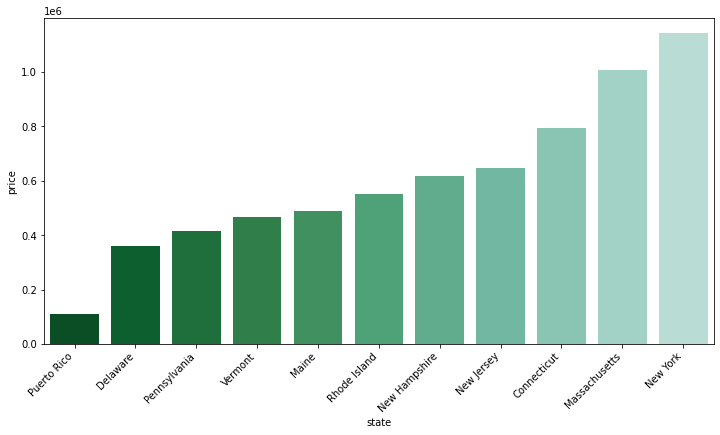

In [26]:
state_prices = df[['state','price']].groupby('state').mean().sort_values(by='price')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=state_prices.index, y=state_prices['price'], palette=sns.color_palette("BuGn_r", n_colors=len(state_prices) + 4), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

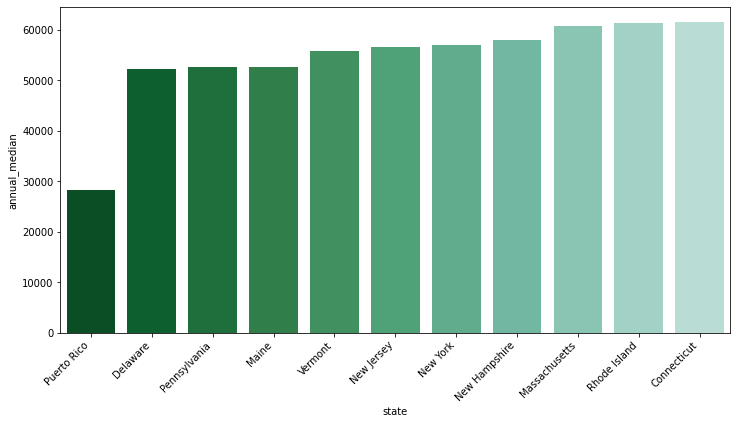

In [27]:
state_prices = df[['state','annual_median']].groupby('state').mean().sort_values(by='annual_median')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=state_prices.index, y=state_prices['annual_median'], palette=sns.color_palette("BuGn_r", n_colors=len(state_prices) + 4), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### Looks like there is some correlation between housing cost and median wages

In [29]:
freq_df.head(5)

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,annual_median
0,110000.0,7.0,3.0,0.09,1,1,1,1192.0,1.561680e+09,28377.754237
1,525000.0,3.0,3.0,0.45,8,3307,4,2314.0,1.403654e+09,61829.452055
2,289900.0,3.0,2.0,0.36,8,3307,4,1276.0,1.350000e+09,61829.452055
3,384900.0,3.0,2.0,0.46,8,3307,4,1476.0,5.328288e+08,61829.452055
4,199999.0,3.0,2.0,1.76,8,3307,4,1968.0,1.221782e+09,61829.452055


In [30]:
hashed_df.head(5)

,price,bed,bath,acre_lot,house_size,sold_date,annual_median,zip_code1,zip_code2,zip_code3,...,zip_code16,zip_code17,zip_code18,zip_code19,zip_code20,zip_code21,zip_code22,zip_code23,zip_code24,zip_code25
0,110000.0,7.0,3.0,0.09,1192.0,1.561680e+09,28377.754237,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0,0.0,0.0
1,525000.0,3.0,3.0,0.45,2314.0,1.403654e+09,61829.452055,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,289900.0,3.0,2.0,0.36,1276.0,1.350000e+09,61829.452055,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,384900.0,3.0,2.0,0.46,1476.0,5.328288e+08,61829.452055,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199999.0,3.0,2.0,1.76,1968.0,1.221782e+09,61829.452055,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
from min_max_scaler import MinMaxScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from pprint import pprint

def calc_rsme(x, y):
    return np.sqrt(np.sum((x-y)**2)/len(y))

def train_model(model, params, df_grid, feature, grid=False):
    scores = {}
    for df_name in df_grid.keys():
        print(f'training on {df_name}')
        df = df_grid[df_name]
        scores[df_name] = {}
        
        X = df.drop(feature, axis=1).values
        y = df[feature].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        
        # turn off negative scaling since there is no concept of negative in our features
        mms = MinMaxScaler(negative_scale=False)
        X_train = mms.fit_transform(X_train)
        X_test = mms.transform(X_test)

        if grid:
            search = GridSearchCV(model, scoring='neg_root_mean_squared_error', cv=10, # neg_root_mean_squared_error
                                     param_grid=params, refit=True, n_jobs=-1)
        else:
            # np.prod produces 1 for empty list.
            max_iter = np.prod([len(val) for val in params.values()])

            if max_iter < 12:
                iters = max_iter
            else:
                iters = 12

            search = RandomizedSearchCV(model, scoring='neg_root_mean_squared_error', cv=10,
                                        n_iter=iters, param_distributions=params,
                                        refit=True, n_jobs=-1)
        
        search.fit(X_train, y_train)

        best_model = search.best_estimator_
        
        # negative since the RandomizedSearchCV uses negative root mean squared error
        best_params = search.best_params_
        preds = best_model.predict(X_test)
        rsme = calc_rsme(preds, y_test)
        
        scores[df_name]['rsme'] = rsme
        scores[df_name]['r2_test'] = best_model.score(X_test, y_test)
        scores[df_name]['r2_train'] = best_model.score(X_train, y_train)
        scores[df_name]['params'] = best_params
        
        print(f'done training on {df_name}')

    return scores

In [33]:
df_grid = { 'imputed_hashed_features': hashed_df, 'imputed_frequency_features': freq_df }

In [34]:
params = { 'positive': [True, False] }
scores = train_model(LinearRegression(), params, df_grid, 'price', grid=True)
pprint(scores)

training on imputed_hashed_features
done training on imputed_hashed_features
training on imputed_frequency_features
done training on imputed_frequency_features
{'imputed_frequency_features': {'params': {'positive': False},
                                'r2_test': 0.3656491982996152,
                                'r2_train': 0.3552615680427965,
                                'rsme': 902995.5165677371},
 'imputed_hashed_features': {'params': {'positive': False},
                             'r2_test': 0.3456369058098874,
                             'r2_train': 0.36476398755561856,
                             'rsme': 878575.9839095805}}


### Linear model does not perform well, need to go non-linear. Let's try some non-linear models.

In [35]:
params = {'n_neighbors': [2,5,10,15,20], 'weights': ['distance', 'uniform'], 'p': [1,2]}
scores = train_model(KNeighborsRegressor(), params, df_grid, 'price')
pprint(scores)

training on imputed_hashed_features
done training on imputed_hashed_features
training on imputed_frequency_features
done training on imputed_frequency_features
{'imputed_frequency_features': {'params': {'n_neighbors': 20,
                                           'p': 1,
                                           'weights': 'uniform'},
                                'r2_test': 0.5980253188399418,
                                'r2_train': 0.5849826182762918,
                                'rsme': 727307.8129542491},
 'imputed_hashed_features': {'params': {'n_neighbors': 5,
                                        'p': 1,
                                        'weights': 'distance'},
                             'r2_test': 0.5235674639630323,
                             'r2_train': 0.9999997606205812,
                             'rsme': 857946.786007775}}


In [36]:
# After several attempts we see it goes full pure ~30 nodes
params = {'splitter': ['best', 'random'], 'min_samples_split': [2, 20, 30, 40, 60], 'max_depth': [None,10,20]}
scores = train_model(DecisionTreeRegressor(), params, df_grid, 'price', grid=True)
pprint(scores)

training on imputed_hashed_features
done training on imputed_hashed_features
training on imputed_frequency_features
done training on imputed_frequency_features
{'imputed_frequency_features': {'params': {'max_depth': 10,
                                           'min_samples_split': 60,
                                           'splitter': 'random'},
                                'r2_test': 0.4136994562645565,
                                'r2_train': 0.5021985475158238,
                                'rsme': 1094663.248710657},
 'imputed_hashed_features': {'params': {'max_depth': None,
                                        'min_samples_split': 30,
                                        'splitter': 'random'},
                             'r2_test': 0.39966905342465675,
                             'r2_train': 0.6253356298979605,
                             'rsme': 990115.9795576616}}


In [ ]:
# this one takes some time to train
params = {'n_estimators': [10,50,100], 'max_depth': [None,10,20], 'ccp_alpha': [0.01, 0.02, 0.03]}
scores = train_model(RandomForestRegressor(), params, df_grid, 'price')
pprint(scores)

training on imputed_hashed_features


In [97]:
# eta is learning rate
params = {'eta': [0.05,0.1,0.15], 'gamma': [0, 1, 10], 'max_depth': [3, 6, 10], 'lambda': [1,5,10]}
scores = train_model(XGBRegressor(), params, df_grid, 'price')
pprint(scores)

training on imputed_frequency_features
done training on imputed_frequency_features
training on imputed_median_by_zip
done training on imputed_median_by_zip
{'imputed_frequency_features': {'params': {'eta': 0.05,
                                           'gamma': 1,
                                           'lambda': 5,
                                           'max_depth': 10},
                                'r2_test': 0.5814352976770683,
                                'r2_train': 0.9016352937808998,
                                'rsme': 888211.0938630328},
 'imputed_median_by_zip': {'params': {'eta': 0.15,
                                      'gamma': 10,
                                      'lambda': 1,
                                      'max_depth': 3},
                           'r2_test': 0.6499765430493842,
                           'r2_train': 0.8069368160147561,
                           'rsme': 741292.5589561899}}


# Analysis
### Feature Engineering
1. Hashing the zip code feature did not offer much increased performance over simple frequency mapping. Furthermore, the additional complexity caused this feature set to take a much longer time to train the models. If scaled up to more data, it would not perform well.

2. Although not shown in the analysis above due to the time it took to train each model, it was tested to see if dropping NA values for bed, bath, and house_size was better than imputing, and imputing outperformed the dropped dataset every single time, therefore imputing the l

3. Downsides to adding median by zip as a feature: If we see a zip code we have not seen before, we will not have this information.